In [6]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from nflows import transforms, distributions, flows
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet

from IPython.display import clear_output

import sys
sys.path.append("..")
from mestrado import datasets
from mestrado.datasets import databases_ce_pairs

In [22]:
databases_ce_pairs

{'breast_tumor': [('tumor_size', 'inv_nodes'), ('tumor_size', 'deg_malig')],
 'cholesterol': [('chol', 'trestbps'), ('chol', 'fbs')],
 'pbc': [('stage', 'albumin'), ('stage', 'protime'), ('stage', 'bili')],
 'pollution': [('mort', 'ovr65')],
 'autompg': [('horsepower', 'mpg'), ('weight', 'mpg')],
 'cpu': [('myct', 'erp'), ('mmax', 'erp'), ('cach', 'erp')],
 'breastw': [('target', 'Clump_Thickness'),
  ('target', 'Cell_Shape_Uniformity'),
  ('target', 'Cell_Size_Uniformity')],
 'balance_scale': [('left_weight', 'target'),
  ('right_weight', 'target'),
  ('left_distance', 'target'),
  ('right_distance', 'target')],
 'servo': [('pgain', 'class'), ('vgain', 'class')],
 'sensory': [('trellis', 'score')],
 'pwlinear': [('a1', 'binaryClass'),
  ('a2', 'binaryClass'),
  ('a3', 'binaryClass'),
  ('a4', 'binaryClass'),
  ('a5', 'binaryClass'),
  ('a6', 'binaryClass'),
  ('a7', 'binaryClass'),
  ('a8', 'binaryClass'),
  ('a9', 'binaryClass'),
  ('a10', 'binaryClass')],
 'wisconsin': [('diagnosis'

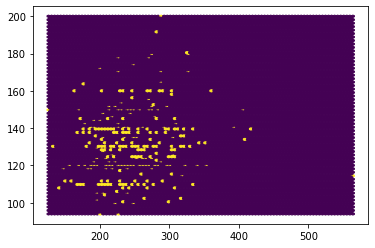

In [27]:
df = datasets.load_cholesterol()

df = df[['chol', 'trestbps']].copy()
df.columns = ['X', 'Y']
plt.hexbin(df['X'], df['Y'], bins=2)

In [28]:
def make_nn(num_layers=5, num_features=2, num_hidden=4):
    transforms = []
    for _ in range(num_layers):
        transforms.append(ReversePermutation(features=num_features))
        transforms.append(MaskedAffineAutoregressiveTransform(features=num_features, hidden_features=num_hidden))
    
    transform = CompositeTransform(transforms)
    base_distribution = distributions.StandardNormal(shape=[num_features])
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    return flow


def plot_density(df, flow):
    fig, ax = plt.subplots(figsize=(8, 5))
    xline = torch.linspace(df.X.min(), df.X.max(), 100)
    yline = torch.linspace(df.Y.min(), df.Y.max(), 100)
    xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)
    
    with torch.no_grad():
        zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)
        
    ax.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
    plt.title('iteration {}'.format(i + 1))
    plt.tight_layout()
    plt.show()
        

In [29]:
flow_xy = make_nn(num_layers=4)
flow_x = make_nn(num_features=1)
flow_y = make_nn(num_features=1)

In [ ]:
def train_model(model, df, optimizer, num_iterations=100):
    for i in range(num_iterations):
        x = df.values
        x = torch.tensor(x, dtype=torch.float32)
        optimizer.zero_grad()
        loss = -model.log_prob(inputs=x).mean()
        loss.backward()
        optimizer.step()
    
    return model, optimizer

tensor(9.5370, grad_fn=<NegBackward0>)


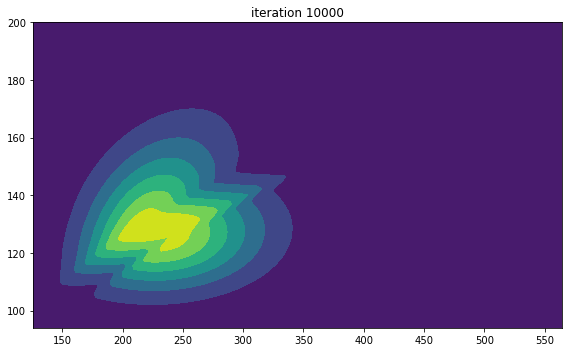

In [30]:
optimizer = optim.Adam(flow_xy.parameters())

num_iter = 10000
for i in range(num_iter):
    x = df.values
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow_xy.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        clear_output(wait=True)
        print(loss)
        plot_density(df, flow_xy)

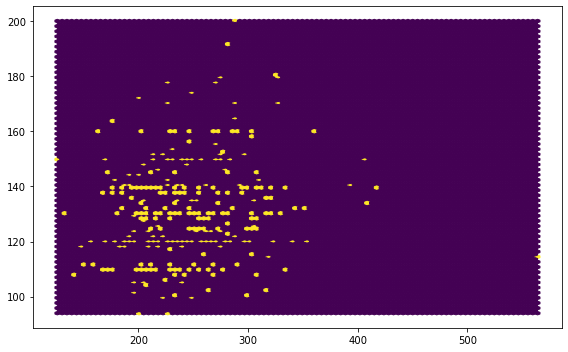

In [35]:
plt.figure(figsize=(8, 5))
plt.hexbin(df['X'], df['Y'], bins=2)
plt.tight_layout()
plt.show()

In [143]:
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=1))
    transforms.append(MaskedAffineAutoregressiveTransform(features=1, 
                                                          hidden_features=4, 
                                                          context_features=1))
 
transform_u = CompositeTransform(transforms)

base_distribution_u = distributions.StandardNormal(shape=[1])

flow_x = flows.Flow(transform=transform_u, distribution=base_distribution_u)
flow_y = flows.Flow(transform=transform_u, distribution=base_distribution_u)

In [144]:
optimizer_x = optim.Adam(flow_x.parameters())

tensor(5.0729, grad_fn=<NegBackward0>)


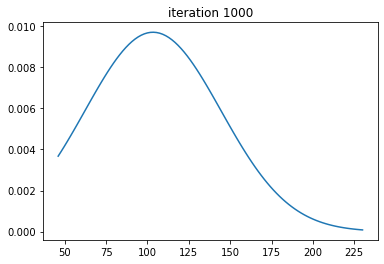

tensor(5.0681, grad_fn=<NegBackward0>)


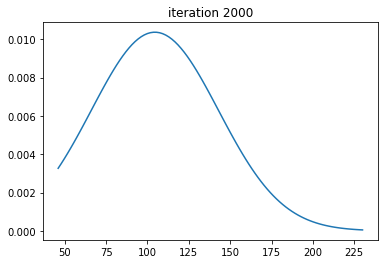

tensor(5.0681, grad_fn=<NegBackward0>)


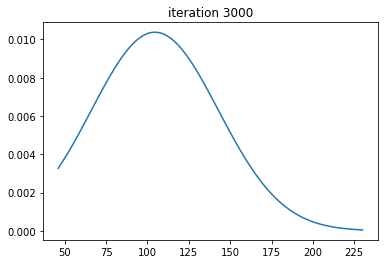

tensor(5.0681, grad_fn=<NegBackward0>)


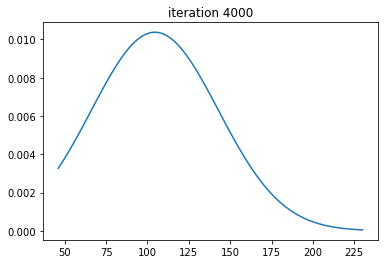

tensor(5.0681, grad_fn=<NegBackward0>)


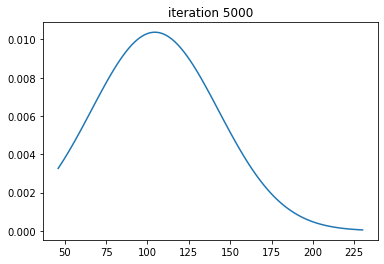

tensor(5.0681, grad_fn=<NegBackward0>)


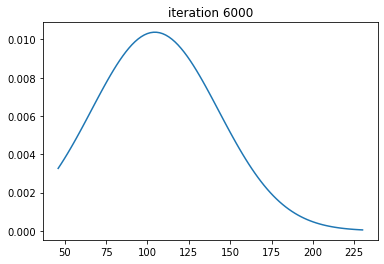

tensor(5.0681, grad_fn=<NegBackward0>)


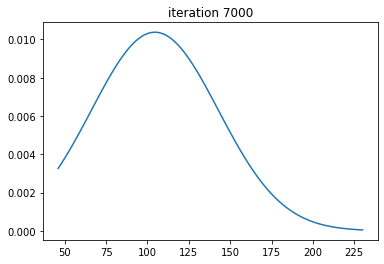

tensor(5.0681, grad_fn=<NegBackward0>)


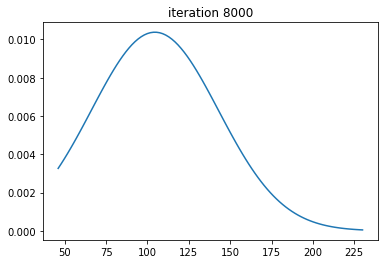

tensor(5.0681, grad_fn=<NegBackward0>)


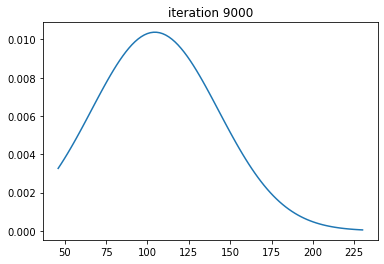

tensor(5.0681, grad_fn=<NegBackward0>)


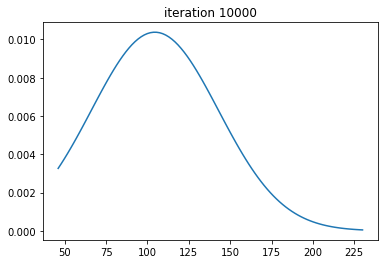

In [145]:
num_iter = 10000
for i in range(num_iter):
    x = df.X.values.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer_x.zero_grad()
    loss = -flow_x.log_prob(inputs=x).mean()
    loss.backward()
    optimizer_x.step()
    
    if (i + 1) % 1000 == 0:
        print(loss)
        fig, ax = plt.subplots()
        xline = torch.linspace(df.X.min(), df.X.max()).reshape(-1, 1)

        with torch.no_grad():
            l_prob = flow_x.log_prob(xline).exp()
        
        ax.plot(xline.numpy(), l_prob.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

In [147]:
optimizer_y = optim.Adam(flow_y.parameters())

(array([15., 67., 59., 84., 51., 15., 14., 42.,  8., 15.,  8.,  4.,  5.,
         5.]),
 array([ 46.        ,  59.14285714,  72.28571429,  85.42857143,
         98.57142857, 111.71428571, 124.85714286, 138.        ,
        151.14285714, 164.28571429, 177.42857143, 190.57142857,
        203.71428571, 216.85714286, 230.        ]),
 <BarContainer object of 14 artists>)

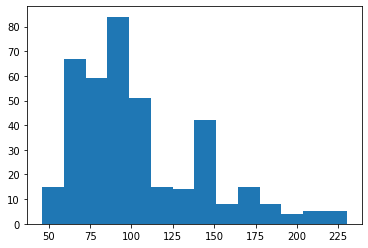

In [173]:
plt.hist(df['X'], bins='auto')

tensor(3.4724, grad_fn=<NegBackward0>)


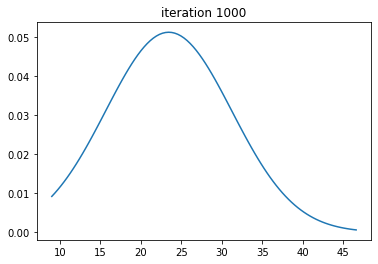

tensor(3.4724, grad_fn=<NegBackward0>)


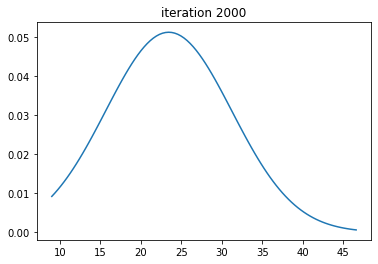

tensor(3.4724, grad_fn=<NegBackward0>)


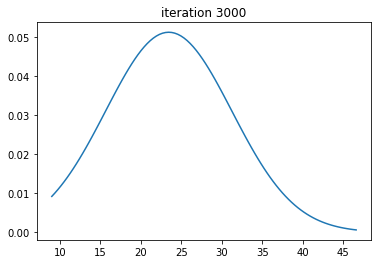

tensor(3.4724, grad_fn=<NegBackward0>)


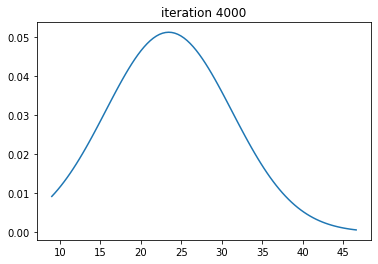

tensor(3.4724, grad_fn=<NegBackward0>)


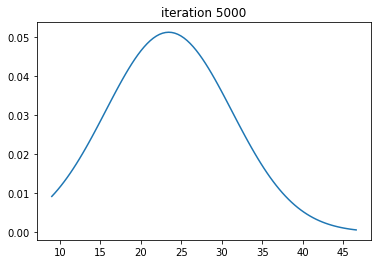

tensor(3.4724, grad_fn=<NegBackward0>)


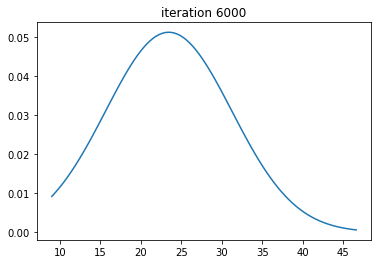

tensor(3.4724, grad_fn=<NegBackward0>)


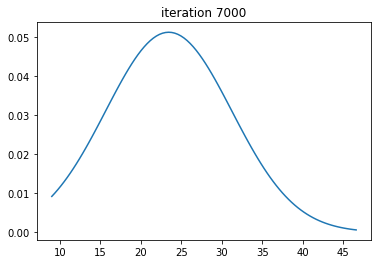

tensor(3.4724, grad_fn=<NegBackward0>)


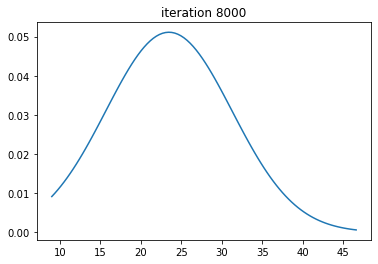

tensor(3.4724, grad_fn=<NegBackward0>)


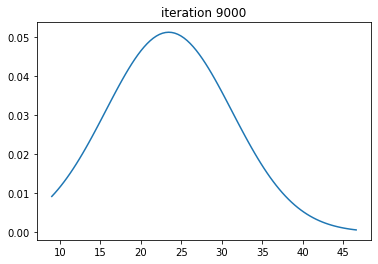

tensor(3.4724, grad_fn=<NegBackward0>)


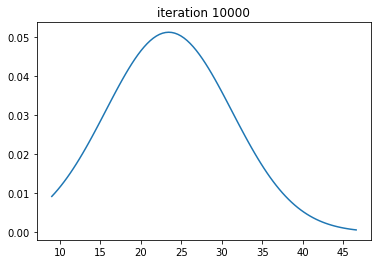

In [148]:
num_iter = 10000
for i in range(num_iter):
    x = df.Y.values.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer_y.zero_grad()
    loss = -flow_y.log_prob(inputs=x).mean()
    loss.backward()
    optimizer_y.step()
    
    if (i + 1) % 1000 == 0:
        print(loss)
        fig, ax = plt.subplots()
        xline = torch.linspace(df.Y.min(), df.Y.max()).reshape(-1, 1)

        with torch.no_grad():
            l_prob = flow_y.log_prob(xline).exp()
        
        ax.plot(xline.numpy(), l_prob.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

(array([13., 56., 58., 55., 44., 49., 38., 37., 23., 11.,  4.,  4.]),
 array([ 9.        , 12.13333333, 15.26666667, 18.4       , 21.53333333,
        24.66666667, 27.8       , 30.93333333, 34.06666667, 37.2       ,
        40.33333333, 43.46666667, 46.6       ]),
 <BarContainer object of 12 artists>)

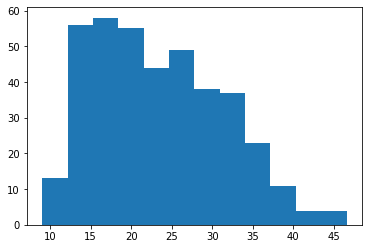

In [150]:
plt.hist(df['Y'], bins='auto')

In [151]:
log_prob_xy = flow_xy.log_prob(df.values.astype(np.float32)).detach().numpy()
log_prob_x = flow_x.log_prob(df.X.values.astype(np.float32).reshape(-1, 1)).detach().numpy()
log_prob_y = flow_y.log_prob(df.Y.values.astype(np.float32).reshape(-1, 1)).detach().numpy()

mean_divergence_x = np.mean(log_prob_xy - log_prob_x)
mean_divergence_y = np.mean(log_prob_xy - log_prob_y)

In [152]:
print(mean_divergence_x)
print(mean_divergence_y)
print(mean_divergence_x - mean_divergence_y)

61.506203
-4.1743426
65.68054


In [153]:
xline = torch.linspace(df.X.min(), df.X.max())
yline = torch.linspace(df.Y.min(), df.Y.max())
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid = flow_xy.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)

In [174]:
xline_y = torch.linspace(df.Y.min(), df.Y.max()).reshape(-1, 1)

with torch.no_grad():
    prob_y = flow_y.log_prob(xline_y)

In [175]:
xline_x = torch.linspace(df.X.min(), df.X.max()).reshape(-1, 1)

with torch.no_grad():
    prob_x = flow_x.log_prob(xline_x)

In [184]:
l_x = ((zgrid.numpy()/prob_y.numpy()).max(axis=1) * prob_x.numpy()).max()
l_y = ((zgrid.numpy()/prob_x.numpy()).max(axis=1) * prob_y.numpy()).max()
print(l_x)
print(l_y)

3.485554e-16
8.707323e-17


In [185]:
l_x/l_y

4.0030146

In [178]:
prob_x

tensor([  -7.1583,   -7.8766,   -8.6518,   -9.4838,  -10.3726,  -11.3183,
         -12.3209,  -13.3803,  -14.4965,  -15.6696,  -16.8996,  -18.1864,
         -19.5300,  -20.9305,  -22.3879,  -23.9021,  -25.4731,  -27.1010,
         -28.7858,  -30.5274,  -32.3258,  -34.1811,  -36.0933,  -38.0623,
         -40.0881,  -42.1708,  -44.3104,  -46.5068,  -48.7600,  -51.0701,
         -53.4371,  -55.8609,  -58.3415,  -60.8790,  -63.4733,  -66.1245,
         -68.8326,  -71.5975,  -74.4193,  -77.2979,  -80.2333,  -83.2256,
         -86.2747,  -89.3807,  -92.5435,  -95.7632,  -99.0398, -102.3732,
        -105.7635, -109.2106, -112.7145, -116.2753, -119.8930, -123.5674,
        -127.2988, -131.0870, -134.9320, -138.8339, -142.7927, -146.8083,
        -150.8807, -155.0099, -159.1961, -163.4391, -167.7389, -172.0956,
        -176.5092, -180.9796, -185.5068, -190.0909, -194.7318, -199.4296,
        -204.1843, -208.9958, -213.8641, -218.7893, -223.7713, -228.8102,
        -233.9060, -239.0585, -244.267